In [31]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt

In [33]:
input_texts = ['hello', 'how are you', 'good morning', 'thank you']
target_texts = ['hola', 'como estas', 'buenos dias', 'gracias']
target_texts = ['\t' + text + '\n' for text in target_texts]

In [34]:
from tensorflow.keras.preprocessing.text import Tokenizer

# Input Tokenizer
input_tokenizer = Tokenizer(char_level=True)
input_tokenizer.fit_on_texts(input_texts)
input_sequences = input_tokenizer.texts_to_sequences(input_texts)
input_sequences = pad_sequences(input_sequences, padding='post')

# Target Tokenizer
target_tokenizer = Tokenizer(char_level=True)
target_tokenizer.fit_on_texts(target_texts)
target_sequences = target_tokenizer.texts_to_sequences(target_texts)
target_sequences = pad_sequences(target_sequences, padding='post')

input_vocab_size = len(input_tokenizer.word_index) + 1
target_vocab_size = len(target_tokenizer.word_index) + 1

print("Input vocab size:", input_vocab_size)
print("Target vocab size:", target_vocab_size)

Input vocab size: 18
Target vocab size: 20


In [35]:
encoder_input_data = input_sequences
decoder_input_data = [seq[:-1] for seq in target_sequences]
decoder_target_data = [seq[1:] for seq in target_sequences]

# Padding
decoder_input_data = pad_sequences(decoder_input_data, padding='post')
decoder_target_data = pad_sequences(decoder_target_data, padding='post')

# One-hot encode target for categorical_crossentropy
decoder_target_data_onehot = to_categorical(decoder_target_data, num_classes=target_vocab_size)

In [36]:
embedding_dim = 64
latent_dim = 128

# Encoder
encoder_inputs = Input(shape=(None,))
enc_emb = Embedding(input_vocab_size, embedding_dim)(encoder_inputs)
encoder_lstm, state_h, state_c = LSTM(latent_dim, return_state=True)(enc_emb)
encoder_states = [state_h, state_c]

# Decoder
decoder_inputs = Input(shape=(None,))
dec_emb = Embedding(target_vocab_size, embedding_dim)(decoder_inputs)
decoder_lstm, _, _ = LSTM(latent_dim, return_sequences=True, return_state=True)(dec_emb, initial_state=encoder_states)
decoder_dense = Dense(target_vocab_size, activation='softmax')
decoder_outputs = decoder_dense(decoder_lstm)

model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

In [37]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_3       │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_2         │ (None, None, 64)  │      1,152 │ input_layer_2[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_3         │ (None, None, 64)  │      1,280 │ input_layer_3[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_2 (LSTM)       │ [(None, 128),     │     98,816 │ embedding_2[0][0] │
│                     │ (None, 128),      │            │                   │
│                     │ (None, 128)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_3 (LSTM)       │ [(None, None,     │     98,816 │ embedding_3[0][0… │
│                     │ 128), (None,      │            │ lstm_2[0][1],     │
│                     │ 128), (None,      │            │ lstm_2[0][2]      │
│                     │ 128)]             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, None, 20)  │      2,580 │ lstm_3[0][0]      │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 202,644 (791.58 KB)

 Trainable params: 202,644 (791.58 KB)

 Non-trainable params: 0 (0.00 B)

In [38]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(
    [encoder_input_data, decoder_input_data],
    decoder_target_data_onehot,
    batch_size=2,
    epochs=10,
    validation_split=0.2,
    verbose=1
)

Epoch 1/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 456ms/step - accuracy: 0.0000e+00 - loss: 2.9935 - val_accuracy: 0.3333 - val_loss: 2.9770
Epoch 2/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.2917 - loss: 2.9692 - val_accuracy: 0.3333 - val_loss: 2.9596
Epoch 3/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.2917 - loss: 2.9436 - val_accuracy: 0.3333 - val_loss: 2.9383
Epoch 4/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.2639 - loss: 2.9154 - val_accuracy: 0.3333 - val_loss: 2.9073
Epoch 5/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.2917 - loss: 2.8700 - val_accuracy: 0.3333 - val_loss: 2.8577
Epoch 6/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.2639 - loss: 2.8085 - val_accuracy: 0.3333 - val_loss: 2.7690
Epoch 7/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - accuracy: 0.2917 - loss: 2.6894 - val_accuracy: 0.3333 - val_loss: 2.6061
Epoch 8/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.2639 - loss: 2.5105 - val_accuracy: 0.3333 - val_loss: 2

In [39]:
for i in range(len(history.history['loss'])):
    print(f"Epoch {i+1}: Loss = {history.history['loss'][i]:.4f}, Accuracy = {history.history['accuracy'][i]:.4f}")

Epoch 1: Loss = 2.9935, Accuracy = 0.0000
Epoch 2: Loss = 2.9720, Accuracy = 0.2500
Epoch 3: Loss = 2.9489, Accuracy = 0.2500
Epoch 4: Loss = 2.9199, Accuracy = 0.2500
Epoch 5: Loss = 2.8829, Accuracy = 0.2500
Epoch 6: Loss = 2.8193, Accuracy = 0.2500
Epoch 7: Loss = 2.7236, Accuracy = 0.2500
Epoch 8: Loss = 2.5387, Accuracy = 0.2500
Epoch 9: Loss = 2.3447, Accuracy = 0.2222
Epoch 10: Loss = 2.3001, Accuracy = 0.2500


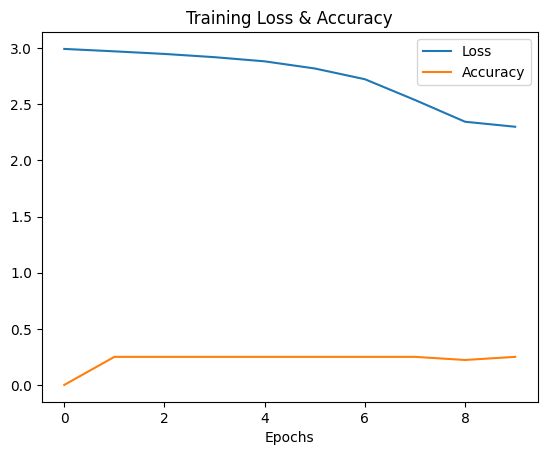

In [45]:
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['accuracy'], label='Accuracy')
plt.title("Training Loss & Accuracy")
plt.xlabel("Epochs")
plt.legend()
plt.show()